# tr1-13B-codecarbon : An Analysis of the logs

# Introduction

This notebook aims to analyse the CodeCarbon logs captured during training of tr1 13Bn parameters model on 512 GPUs.

## Experimental Setup

This set of records captures the startup time and 2499 iterations in 2 records per gpu, since there was also an intermediary checkpoint saved half-way and we flush the CC 
records on each checkpoint saving.

The training had 168000 iterations. Therefore multiply the reported data by 67. This would be quite approximate since we were using 16 nodes when doing 
the ramp up, then 64 and only the last 3 weeks 128 nodes.

Caveat emptor: I'm not sure whether CC-reports overlap since each report is per gpu and I think they may be measuring the same thing, other than the gpu itself. 
So this requires research.

## Data
The logs can be downloaded [here](https://huggingface.co/bigscience/tr1-13B-codecarbon) and should be put in the current folder.
Each csv file contains a report for a single gpu. 

## Current results

- 2 durations per GPU as expected
- Issue with RAM/CPU power measurements, possibly inverted
- Power distribution for GPU looking about right

## Next steps
- Figure the CPU number issue
- Figure the overlap in the data captured
- Get an estimation of energy per training step to be able to extrapolate to the full training.

In [91]:
import pandas as pd
import matplotlib
import os
import numpy as np

In [199]:
# Read files into a single DataFrame
directory = "Project-end/"
file_paths = [directory+x for x in os.listdir(directory) if x.endswith("logs.txt")]
df_list = [pd.read_csv(filename, sep="|", header=None).assign(file=filename.split("/")[1]) for filename in file_paths]
df = pd.concat(df_list)
df.columns= ['job_id', 'num_V100_32GB', 'num_V100_16GB', 'num_A100_40GB', 'num_A100_80GB', \
             'alloc_cpu', 'alloc_mem', 'alloc_energy', 'partition', 'group', 'elapsed',\
              'qos','jobname', 'start', 'end', 'workdir', 'account' ,'file']
df=df.drop('workdir', axis=1)
df.head()

,job_id,num_V100_32GB,num_V100_16GB,num_A100_40GB,num_A100_80GB,alloc_cpu,alloc_mem,alloc_energy,partition,group,elapsed,qos,jobname,start,end,account,file
0,1591099,0,0,0,0,NaN,NaN,NaN,gpu_p2l,genhug01,00:00:00,qos_gpu-t4,second_lm_balanced_prompted,2021-05-14T23:59:03,2021-05-14T23:59:03,ajs@gpu,2022_08_25_victorsanh_jz_logs.txt
1,1591866,0,4,0,0,20.0,40G,36261.0,gpu_p13,genhug01,00:02:11,qos_gpu-t3,second_lm_balanced_prompted,2021-05-15T00:00:15,2021-05-15T00:02:26,ajs@gpu,2022_08_25_victorsanh_jz_logs.txt
2,1797289,0,0,0,0,2.0,4G,10554.0,cpu_p1,genhug01,00:00:30,qos_cpu-t3,bash,2021-05-21T17:44:19,2021-05-21T17:44:49,ajs@cpu,2022_08_25_victorsanh_jz_logs.txt
3,1820136,0,0,0,0,NaN,NaN,NaN,gpu_p2,genhug01,00:00:00,qos_gpu-t4,bash,2021-05-24T16:50:48,2021-05-24T16:50:48,ajs@gpu,2022_08_25_victorsanh_jz_logs.txt
4,1832144,0,0,0,0,NaN,NaN,NaN,prepost,genhug01,00:00:00,qos_cpu-t4,bash,2021-05-25T02:21:26,2021-05-25T02:21:26,ajs@cpu,2022_08_25_victorsanh_jz_logs.txt


In [200]:
pd.set_option('display.max_columns', 1000)  # or 1000
pd.set_option('display.max_rows', 1000)  # or 1000
pd.set_option('display.max_colwidth', -1) 

/tmp/ipykernel_71483/2296578941.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [202]:
df['start'] = pd.to_datetime(df['start'])
df['end'] = pd.to_datetime(df['end'],  errors='coerce')

In [208]:
#df['duration'] = df['elapsed'].str.replace('\d+-','')
df['duration'] = df['end'] - df['start']

In [205]:
print(pd.Timedelta(df.loc[41517]['end'] - df.loc[41517]['start']))

3 days 00:05:37


In [209]:
df[df['job_id']=='726762']

,job_id,num_V100_32GB,num_V100_16GB,num_A100_40GB,num_A100_80GB,alloc_cpu,alloc_mem,alloc_energy,partition,group,elapsed,qos,jobname,start,end,account,file,duration
41517,726762,0,0,0,384,6144.0,22500G,NaN,gpu_p5,six,2-23:05:37,qos_gpu-gc,tr11-176B-ml,2022-03-25 11:09:19,2022-03-28 11:14:56,NaN,2022_08_02_thomas_wang_jz_logs.txt,3 days 00:05:37


In [210]:
df['duration']

0       0 days 00:00:00
1       0 days 00:02:11
2       0 days 00:00:30
3       0 days 00:00:00
4       0 days 00:00:00
              ...      
39026   0 days 00:09:47
39027   0 days 00:11:51
39028   0 days 00:20:09
39029   0 days 00:20:54
39030   0 days 00:10:45
Name: duration, Length: 177192, dtype: timedelta64[ns]

In [211]:
df['duration'].sum()

Timedelta('5816 days 13:22:40')

In [135]:
df['file'].value_counts()

2022_08_02_thomas_wang_jz_logs.txt      45967
2022_08_08_luciles_logs.txt             39031
2022_08_01_stas_jz_logs.txt             38111
2022_08_25_victorsanh_jz_logs.txt       29049
2022-08-24_tvn_jz_logs.txt              11385
2022_08_01_muennighoff_jz_logs.txt      5139 
2022_08_01_pierrec_jz_logs.txt          4813 
new_hugo_laurencon_jz_logs.txt          2185 
2022_08_24_thomwolf_jz_logs.txt         760  
2022_08_02_younesb_jz_logs.txt          603  
2022_08_24_roman_castagne_logs.txt      110  
2022_08_01_sylvainv_jz_logs.txt         34   
2022_08_08_danielhesslow_jz_logs.txt    5    
Name: file, dtype: int64

In [ ]:
#FOCUS ON BLOOM TRAINING

In [212]:
bloomdf = df[df['jobname'] == 'tr11-176B-ml']
bloomdf.shape

(398, 18)

In [216]:
bloomdf['num_A100_80GB'].value_counts()

384    316
192    27 
0      20 
144    13 
288    8  
1      5  
32     4  
8      2  
16     2  
216    1  
Name: num_A100_80GB, dtype: int64

In [215]:
bloomdf.duration.sum()

Timedelta('118 days 05:40:42')

In [ ]:
# OTHER TRAININGS

In [243]:
traindf = df[df['jobname'].str.startswith('tr')]
traindf = traindf[traindf['jobname'] != 'tr11-176B-ml']
traindf = traindf[~traindf['jobname'].str.contains('sync')]
traindf = traindf[~traindf['jobname'].str.contains('slurm')]
traindf = traindf[~traindf['jobname'].str.contains('move')]
traindf = traindf[~traindf['jobname'].str.contains('eval')]
traindf = traindf[~traindf['jobname'].str.contains('tokenizer')]
traindf.shape

(6430, 18)

In [244]:
traindf['jobname'].value_counts()

tr6e-1B3-prefix-lm                                        1435
tr6f-1B3-prefix-lm                                        1431
tr6g-1B3-prefix-lm                                        1008
tr7d-1B3-alibi                                            433 
tr11                                                      302 
tr11-200B-ml                                              204 
tr8-104B                                                  153 
tr11f-6B3-ml                                              146 
tr8b-104B-cl                                              131 
tr8b-104B-bnb                                             123 
tr8b-104B-emb-norm                                        117 
tr13f-6B3-ml-t0                                           102 
tr5c-1B3-multilingual-alpha-alibi                         81  
tr11c-2B5-ml                                              78  
tr5d-1B3-multilingual-equal-alibi                         73  
tr11e-350M-ml                                          

In [245]:
traindf.duration.sum()

Timedelta('488 days 13:34:21')

In [ ]:
# EVAL

In [247]:
evaldf = df[df['jobname'].str.contains('eval')]
evaldf.shape

(16041, 18)

In [248]:
evaldf['jobname'].value_counts()

eval-tr3                                                                            3643
evaluate_t0                                                                         2337
eval_finetune-t5-xxl-lm-d4-091621                                                   747 
score_eval_finetune-t5-xxl-lm-d4-091621                                             694 
score_eval_finetune-t5-xxl-lm-d4-all-091621                                         671 
eval_baseline                                                                       534 
eval_finetune-t5-xxl-lm-d4-all-091621                                               531 
eval_finetune-t5-xl-lm-d4-091621                                                    530 
eval_finetune-t5-xxl-lm-d4-091621-512                                               530 
eval_finetune-t5-xxl-lm-d4-gpt-091621                                               514 
bs-eval-bloom-176b                                                                  504 
score_eval_finetune-t

In [ ]:
# TOKENIZER

In [249]:
tokendf = df[df['jobname'].str.contains('tokenizer')]
tokendf.shape

(103, 18)

In [250]:
tokendf['jobname'].value_counts()

train_tokenizer                                                 67
modelling-metadata-example-load-model-and-tokenizer             11
modelling-metadata-website-desc-load-model-and-tokenizer        8 
modelling-metadata-html-download-tokenizer-and-model            6 
compare_tokenizers                                              3 
modelling-metadata-entity-beg-load-model-and-tokenizer          2 
modelling-metadata-exp1-subexp3-load-model-and-tokenizer        2 
modelling-metadata-entity-load-model-and-tokenizer              1 
modelling-metadata-exp1-subexp1-load-model-and-tokenizer        1 
modelling-metadata-exp1-subexp2-load-model-and-tokenizer        1 
modelling-metadata-website-desc-load-model-and-tokenizer-25k    1 
Name: jobname, dtype: int64

In [ ]:
## DATA PROCESSING, DOWNLOADING, DEDUPLICATION

In [255]:
datadf = df[df['jobname'].str.contains('data')]
datadf = datadf[~datadf['jobname'].str.contains('token')]
datadf.shape


(29359, 18)

In [256]:
datadf['jobname'].value_counts()

download_all_catalogue_datasets                                                     4507
pseudo_crawl_clean_dataset                                                          4282
preprocess_all_catalogue_datasets                                                   3146
modelling-metadata-c4-dataset-toy-add-metadata-full                                 2925
modelling-metadata-c4-dataset-toy-add-website-desc                                  2844
modelling-metadata-c4-dataset-export-to-jsonlines                                   2801
modelling-metadata-c4-dataset-toy-add-metadata-full-v3                              2761
filter_short_document_all_catalogue_datasets                                        1900
deduplicate_all_catalogue_datasets                                                  1121
modelling-metadata-c4-dataset-toy-add-metadata-full-v2                              873 
convert_datasets_to_jsonl                                                           609 
yong-download_dataset

<AxesSubplot:>

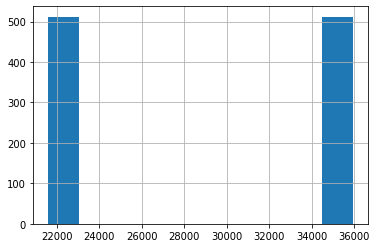

In [71]:
df['duration'].hist()

<AxesSubplot:>

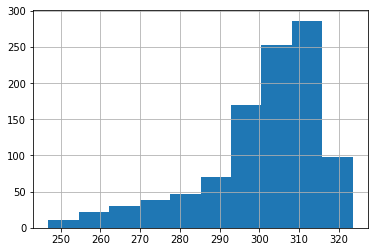

In [69]:
df['gpu_power'].hist()

<AxesSubplot:>

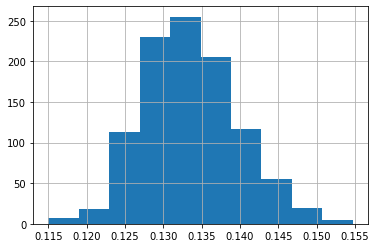

In [66]:
df['cpu_power'].hist()

<AxesSubplot:>

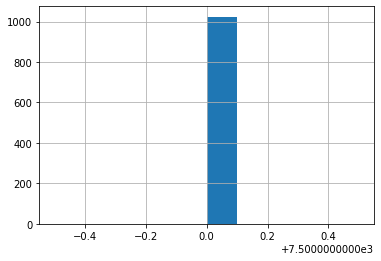

In [70]:
df['ram_power'].hist()